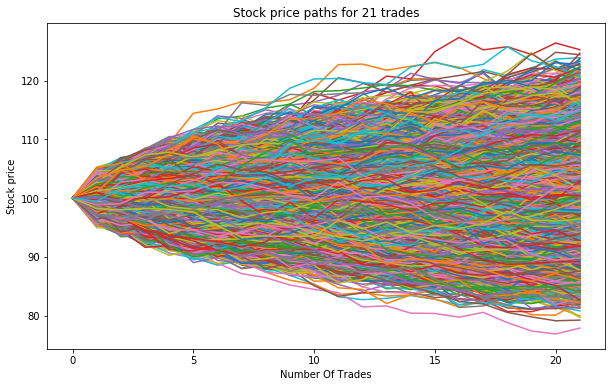

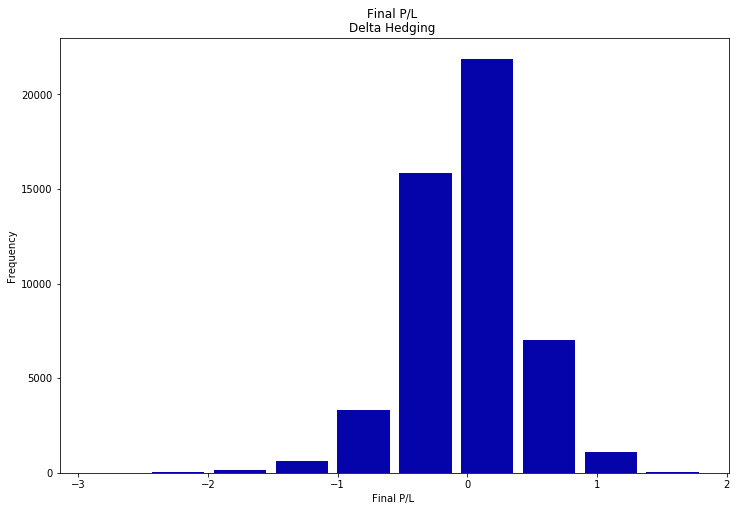

                      Mean  Standard Deviation
Number Of Trades                              
21                0.002654            0.428538


In [3]:
# -*- coding: utf-8 -*-
"""
Created on Thu Nov 20 01:41:06 2018
@author: baichen
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from math import sqrt

class DeltaHedge:
    def __init__(self, S,K,Sigma,R, Trading_Days,NumberOfSimulation,FrequencyPerDay):
        self._S=S
        self._K=K
        self._Sigma=Sigma
        self._R=R
        self._Trading_Days=Trading_Days
        self._NoOfSimulation=NumberOfSimulation
        self._FrequencyPerDay=FrequencyPerDay
        self._NoOftrades=self._Trading_Days*self._FrequencyPerDay
        self._maturity=np.array([np.linspace(self._Trading_Days/252,0.00000001,self._NoOftrades+1),]
                        *self._NoOfSimulation)
        self._dt=1/(252*self._FrequencyPerDay)

        
    def Stock_Simulation(self):
        np.random.seed(2)
        ls=[]
        for s in range(self._NoOfSimulation):
            stock=[0]*(self._NoOftrades+1)
            stock[0]=self._S
            for i in range (1, self._NoOftrades+1):
                shares=stock[i-1]*np.exp((self._R-0.5*self._Sigma**2)*self._dt
                                   +self._Sigma*sqrt(self._dt)*np.random.normal(0,1))
                stock[i]=shares
            ls.append(stock)
        SimulateList=np.array(ls)
        return SimulateList
        
    
    def Plot_Stock(self):
        plt.figure(figsize=(10,6))
        plt.xlabel('Number Of Trades')
        plt.ylabel('Stock price')
        for i in self.Stock_Simulation():
            plt.plot(i)
        plt.title('Stock price paths for {} trades'.format(self._NoOftrades))
        plt.show()
                   
    def OptionCall(self): 
        d1=(np.log(self.Stock_Simulation()/self._K)
            +((self._R+(0.5*self._Sigma**2))/2)*self._maturity)/(self._Sigma*np.sqrt(self._maturity))
        d2=d1-self._Sigma*np.sqrt(self._maturity)
        return self.Stock_Simulation()*norm.cdf(d1) - self._K*np.exp(-self._R*self._maturity)*norm.cdf(d2)
    
    def D1(self):
        return (np.log(self.Stock_Simulation()/self._K)+((self._R
                +(0.5*self._Sigma**2))/2)*self._maturity)/(self._Sigma*np.sqrt(self._maturity))
    
    def delta(self):
        return norm.cdf(self.D1())
    
    def cashflow(self):
        cashflow=[]
        for d,s in zip(self.delta(),self.Stock_Simulation()):
            c=[]
            c.append(0)
            for n in range(1,len(d)):
                c.append((d[n]-d[n-1])*s[n])
            cashflow.append(c) 
        cf=np.array(cashflow)
        return cf
        
    def balance(self):
        balance=[]
        for s,d,c ,cf in zip(self.Stock_Simulation(),self.delta(),self.OptionCall(),self.cashflow()):
            bal=[]
            bal.append(s[0]*d[0]-c[0])
            for n in range(1,len(c)):
                bal.append(bal[n-1]*np.exp(self._R*self._dt)+cf[n])
            balance.append(bal)
        ba=np.array(balance)
        return ba
    
    def HedgingError(self):
        error=[d[-1]*s[-1]-c[-1]-b[-1] for d,s,c,b in zip(self.delta(),self.Stock_Simulation(),
                                                           self.OptionCall(),self.balance())]
        return error
            
    def Plot_Hist(self):
        plt.figure(figsize=(12,8))
        plt.hist(self.HedgingError(),color='#0504aa',rwidth=0.85)
        plt.title('Final P/L \nDelta Hedging ')
        plt.xlabel('Final P/L ')
        plt.ylabel('Frequency')
        plt.show();    
      
    def Table(self):
        table=pd.DataFrame({'Mean':[np.mean(self.HedgingError())],
                            'Standard Deviation':[np.std(self.HedgingError())]},index=[self._NoOftrades])
        table.index.names=['Number Of Trades']
        print(table)
    
def main():
    call21=DeltaHedge(100,100,0.2,0.01,21,50000,1)
    call21.Plot_Stock()
    call21.Stock_Simulation()
    call21.HedgingError()
    call21.Plot_Hist() 
    call21.Table()
main()